<a href="https://colab.research.google.com/github/nivethanancroos/SmartWasteClassifier/blob/main/Smart_Waste_Classification03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

In [22]:
dataset_path = "/content/drive/MyDrive/dataset-resized/dataset-resized"

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # 80/20 split
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # VGG expects 224x224
    batch_size=32,
    class_mode='sparse',     # use sparse_categorical_crossentropy
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',
    subset='validation'
)

Found 2025 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [23]:
# Build optimized VGG-like Model
def build_vgg_like(input_shape=(128,128,3), num_classes=6):
    inp = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Replace Flatten with GlobalAveragePooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Use your dataset's number of classes
num_classes = train_generator.num_classes
model = build_vgg_like(num_classes=num_classes)

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469,158 (1.79 MB)

 Trainable params: 469,158 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Callbacks (to prevent overfitting)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)


In [25]:
# Train the Model

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, lr_reduce]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 387s 6s/step - accuracy: 0.1970 - loss: 1.7569 - val_accuracy: 0.2386 - val_loss: 1.7096 - learning_rate: 1.0000e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 310s 5s/step - accuracy: 0.3246 - loss: 1.6402 - val_accuracy: 0.3062 - val_loss: 1.6425 - learning_rate: 1.0000e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.3699 - loss: 1.5293 - val_accuracy: 0.3340 - val_loss: 1.6155 - learning_rate: 1.0000e-04
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.3904 - loss: 1.4968 - val_accuracy: 0.3300 - val_loss: 1.5910 - learning_rate: 1.0000e-04
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - accuracy: 0.4218 - loss: 1.4302 - val_accuracy: 0.3181 - val_loss: 1.6032 - learning_rate: 1.0000e-04
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 316s 5s/step - accuracy: 0.4607 - loss: 1.3964 - val_accuracy: 0.3817 - val_loss: 1.5086 - learning_rate: 1.0000e-04
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 331s 5s/step - accuracy: 0.4853 

In [48]:
# Evaluate the model on validation data
loss, acc = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc*100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 719ms/step - accuracy: 0.4705 - loss: 1.3021
Validation Loss: 1.2741
Validation Accuracy: 49.30%


Saving download (1).png to download (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


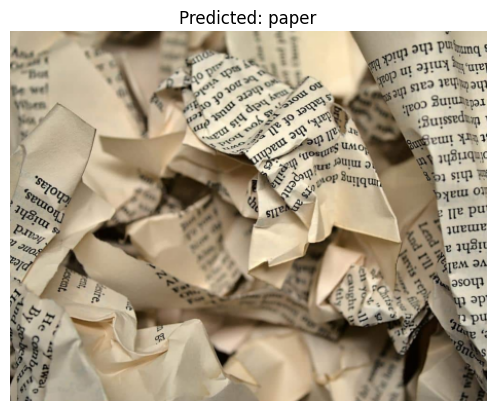

Predicted Category: paper
paper detected → Sorting to Bin 4


In [32]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload an image from your PC
uploaded = files.upload()

for filename in uploaded.keys():
    # Read and preprocess
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Corrected: Resize to (150, 150) to match model input size
    img_resized = cv2.resize(img, (150,150)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    # Prediction
    pred = model.predict(img_input)
    class_idx = np.argmax(pred)
    class_labels = list(train_generator.class_indices.keys())

    # Show result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[class_idx]}")
    plt.show()

    print(f"Predicted Category: {class_labels[class_idx]}")
    print(f"{class_labels[class_idx]} detected → Sorting to Bin {class_idx+1}")

Saving images.jpg to images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


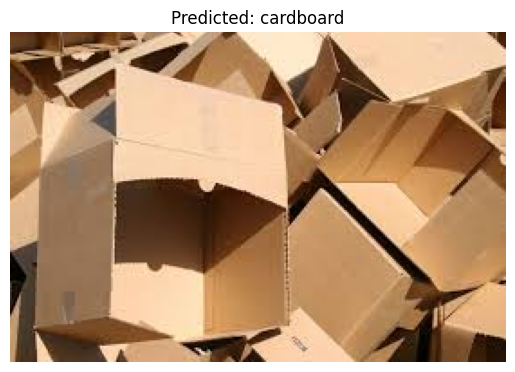

Predicted Category: cardboard
cardboard detected → Sorting to Bin 1


In [33]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload an image from your PC
uploaded = files.upload()

for filename in uploaded.keys():
    # Read and preprocess
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Corrected: Resize to (150, 150) to match model input size
    img_resized = cv2.resize(img, (150,150)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    # Prediction
    pred = model.predict(img_input)
    class_idx = np.argmax(pred)
    class_labels = list(train_generator.class_indices.keys())

    # Show result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[class_idx]}")
    plt.show()

    print(f"Predicted Category: {class_labels[class_idx]}")
    print(f"{class_labels[class_idx]} detected → Sorting to Bin {class_idx+1}")

Saving depositphotos_351200722-stock-photo-plastic-bottles-mediterranean-coast.jpg to depositphotos_351200722-stock-photo-plastic-bottles-mediterranean-coast.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


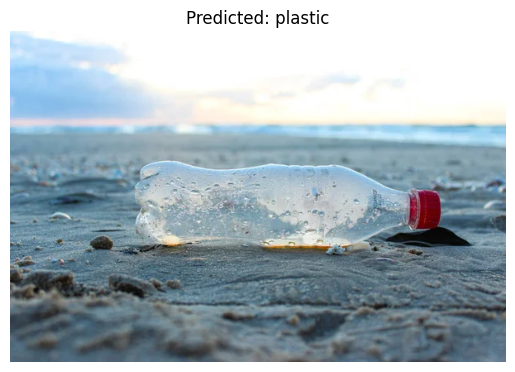

Predicted Category: plastic
plastic detected → Sorting to Bin 5


In [38]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload an image from your PC
uploaded = files.upload()

for filename in uploaded.keys():
    # Read and preprocess
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Corrected: Resize to (150, 150) to match model input size
    img_resized = cv2.resize(img, (150,150)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    # Prediction
    pred = model.predict(img_input)
    class_idx = np.argmax(pred)
    class_labels = list(train_generator.class_indices.keys())

    # Show result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[class_idx]}")
    plt.show()

    print(f"Predicted Category: {class_labels[class_idx]}")
    print(f"{class_labels[class_idx]} detected → Sorting to Bin {class_idx+1}")

In [42]:
# Evaluate the model on validation data
loss, acc = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc*100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 696ms/step - accuracy: 0.4742 - loss: 1.2863
Validation Loss: 1.2531
Validation Accuracy: 50.10%
